# List 2

In [38]:
import imaplib
from pydantic_settings import BaseSettings,SettingsConfigDict
from emails.gmail import  GmailIMAP
from emails.model import  Response
from typing import Any
from functools import lru_cache
import polars as pl
import matplotlib.pyplot as plt

In [2]:
class UserAuth(BaseSettings):
    model_config = SettingsConfigDict(frozen=True, env_file=".env", env_prefix="gmail_")
    
    user: str
    password: str
    imap_url: str = "imap.gmail.com"
    
    @property
    def connection(self):
        return imaplib.IMAP4_SSL(self.imap_url) 
    

In [3]:
USER_AUTH = UserAuth()

In [12]:
def get_message_count(manager: GmailIMAP) -> int:
    resp = manager.select("INBOX")
    if not resp.ok:
        raise SystemExit("Cannot open INBOX")
    return resp.message_count

In [18]:
@lru_cache(maxsize=1)
def get_messages(manager: GmailIMAP, count: int = 100):
    messages = []
    messages_no = min(count, get_message_count(manager))
    print(f"Messages to read: {messages_no}.")
    for i in range (1, messages_no + 1):
        msg_resp = manager.fetch_message(i)
        if msg_resp.ok and msg_resp.message:
            messages.append(msg_resp)
    print(f"Successfully read {len(messages)}.")
    return messages

In [28]:
def analyze_freq_pattern(manager: GmailIMAP, message_max_limit: int = 100):
    messages = get_messages(manager, message_max_limit)
    dates = pl.DataFrame({"Time": [m.message.date for m in messages]})
    return dates


In [30]:
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
dates = analyze_freq_pattern(imap, 10)
imap.conn.logout()

Messages to read: 10.
Successfully read 10.


('BYE', [b'LOGOUT Requested'])

In [34]:
# daily_hist = (
#     dates
#     .with_columns(pl.col("Time").dt.truncate("1d").alias("day"))
#     .group_by("day")
#     .agg(pl.len().alias("count"))
#     .sort("day")
# )

daily_hist = (
    dates.group_by_dynamic(
        index_column="Time",
        every="1d",
        closed="left"
    )
    .agg(pl.len().alias("count"))
)

daily_hist

Time,count
"datetime[μs, Europe/Warsaw]",u32
2021-01-08 00:00:00 CET,2
2021-01-12 00:00:00 CET,5
2021-01-13 00:00:00 CET,2
2021-01-14 00:00:00 CET,1


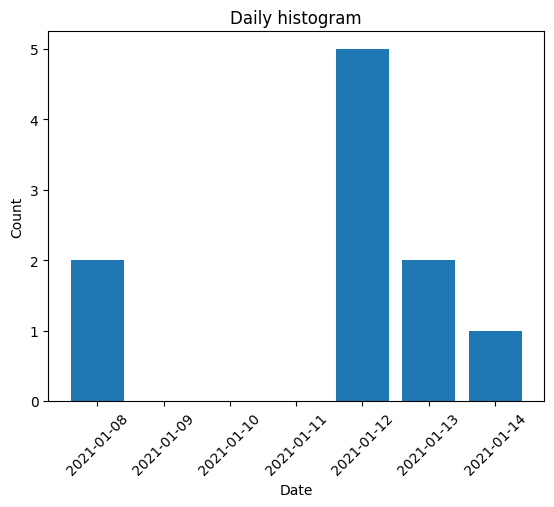

In [ ]:

plt.bar(daily_hist["Time"], daily_hist["count"])
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily histogram")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_sorted = dates.sort("Time")

df_cumsum = df_sorted.with_columns(
    pl.col("volume").cumsum().alias("cum_volume")
)

print(df_cumsum)

[datetime.datetime(2021, 1, 8, 3, 59, 33, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 8, 3, 59, 33, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 12, 11, 32, 37, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 12, 12, 9, 57, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 12, 16, 22, 13, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 12, 18, 30, 19, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 12, 22, 5, 56, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 13, 13, 37, 23, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw')),
 datetime.datetime(2021, 1, 13, 15, 19, 44, tzinfo=zoneinfo.ZoneInfo(key='Europe/Warsaw'))]

In [ ]:
imap.conn.logout()

abort: socket error: [Errno 9] Bad file descriptor